In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from plotly import express as px
from plotly import graph_objects as go

import torch
import torch.nn as nn
import torchvision

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from src.utils import load_best_model, display_image
from src.models import OriginalPretextNetwork, OurPretextNetwork
from src.transforms import RelicAugmentationCreator, TINY_IMAGENET_TRANSFORM

from typing import List, Callable

In [3]:
def get_images(dir: str, n_images: int) -> List[str]:
    """ Return the first `n_images` images that are valid RGB images. """
    fns = os.listdir(dir)

    images = []
    i = 0
    while len(images) < n_images and i < len(fns):
        path = os.path.join(dir, fns[i])
        image = torchvision.io.read_image(path)
        if len(image.shape) == 3 and image.shape[0] == 3: # not grayscale and no alpha channel
            images.append(image / 255)
        i += 1

    return images


def get_embeddings(images: List[torch.Tensor], model: nn.Module) -> np.ndarray:
    """ Compute and return all embeddings using the given model. """
    model.eval()

    embeddings = []
    for img in images:
        x = TINY_IMAGENET_TRANSFORM(img)
        emb = model.get_embedding(img.unsqueeze(0))
        embeddings.append(emb.detach().numpy())
    
    return np.array(embeddings).squeeze()


In [4]:
import collections

def dict_flatten(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(dict_flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def dict_set(dictionary, path, val, sep = '.'):
    curr = dictionary
    p = path.split(sep)
    for i, d in enumerate(p):
        if i == len(p)-1:
            curr[d] = val
            return dictionary
        if d not in curr:
            curr[d] = {}
        curr = curr[d]
            
def dict_get(dictionary, path, sep = '.'):
    curr = dictionary
    p = path.split(sep)
    for i, d in enumerate(p):
        if d in curr:
            if i == len(p) - 1:
                return curr[d]
            curr = curr[d]
        else:
            raise ValueError(f"key {d} not in subdictionary {sep.join(p[:i])}")

## Architecture Image

In [6]:
from src.dataset import OriginalPatchLocalizationDataset, OurPatchLocalizationDataset, extract_patches, get_imagenet_info
imagenet_info = get_imagenet_info()
ds = OurPatchLocalizationDataset(imagenet_info=imagenet_info[:1000])

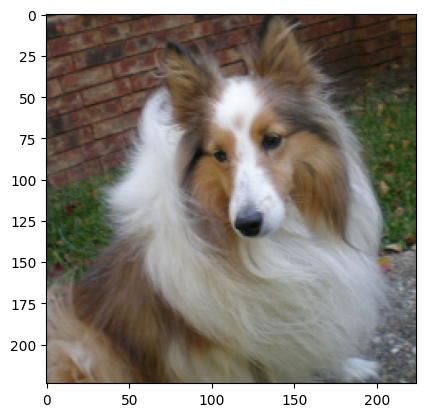

In [7]:
test_image = ds.load_image(2)
display_image(test_image)

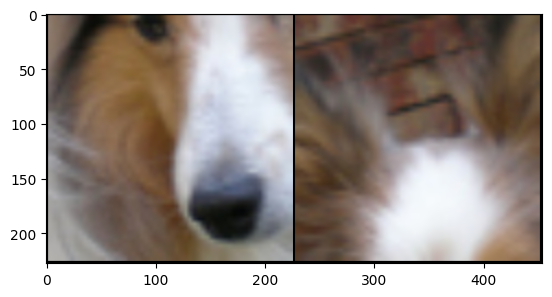

In [8]:
center, neighbor = extract_patches(test_image, 1)

display_image([center, neighbor])

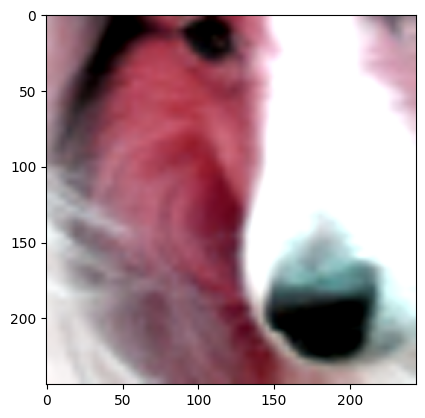

In [112]:
style = rac.get_random_function()


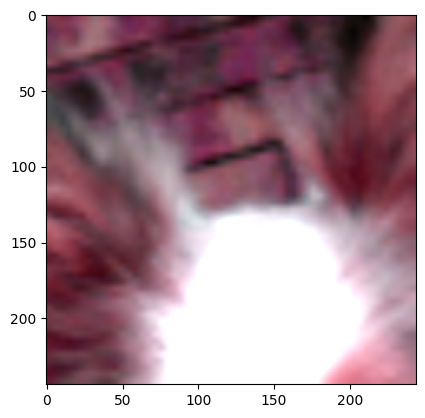

In [113]:
display_image(style(neighbor))

In [114]:
torchvision.utils.save_image(style(neighbor), fp="neighbor_augmented.png")

In [115]:
torchvision.utils.save_image(neighbor, fp="neighbor.png")

In [116]:
torchvision.utils.save_image(center, fp="center.png")

## Embedding Comparison
Load images from 2 different classes

Class 1:


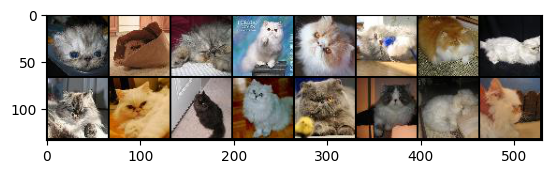

Class 2:


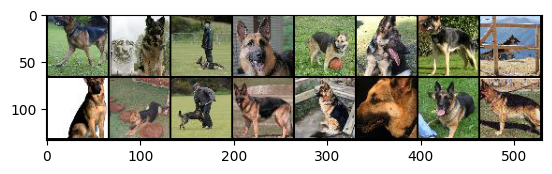

In [9]:
class1_dir = os.path.join("data", "tiny-imagenet-200", "train", "n02123394", "images") # some cats
class2_dir = os.path.join("data", "tiny-imagenet-200", "train", "n02106662", "images") # some dogs

# get 50 images for each class
images1 = get_images(class1_dir, n_images=50)
images2 = get_images(class2_dir, n_images=50)

print("Class 1:")
display_image(images1[:16])
print("Class 2:")
display_image(images2[:16])

Apply 2 different styles all images in both classes. Make sure to generate 2 random functions that are very distinct from each other!

c1, s1


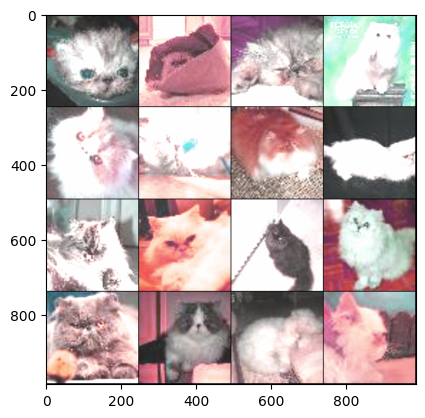

c1, s2


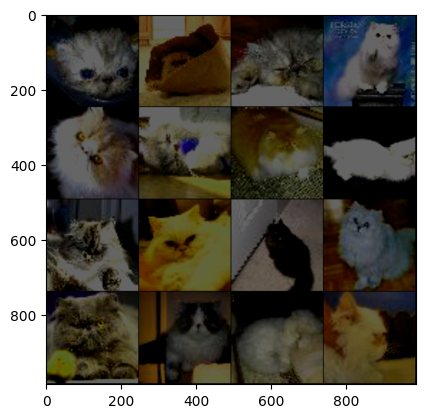

c2, s1


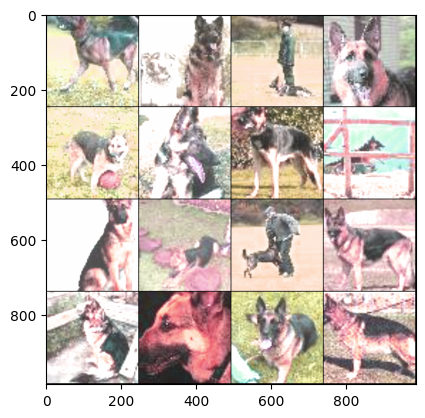

c2, s2


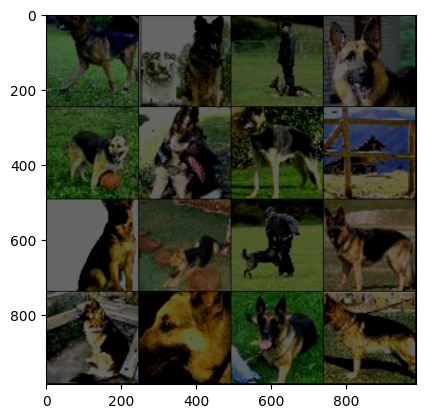

In [31]:
rac = RelicAugmentationCreator(
    min_crop_scale=1.0,
    solarize_prob=0.0,
    grayscale_prob=0.0,
)
style1 = rac.get_random_function()
style2 = rac.get_random_function()

img = {}
dict_set(img, 'c1.s1', [style1(img) for img in images1])
dict_set(img, 'c1.s2', [style2(img) for img in images1])
dict_set(img, 'c2.s1', [style1(img) for img in images2])
dict_set(img, 'c2.s2', [style2(img) for img in images2])

for c in ['c1', 'c2']:
    for s in ['s1', 's2']:
        print(f"{c}, {s}")
        display_image(img[c][s][:16], nrow=4)

### Original Model
Create embeddings of all images using the model from the original approach.

In [32]:
# initialize emb dictionary that we fill up
emb = {}

In [33]:
experiment_id = "original_pretext_resnet18_lr5e5"
original_model = load_best_model(experiment_id, OriginalPretextNetwork(backbone="resnet18"))

# raw embeddings
embeddings = get_embeddings([image for c in img for s in img[c] for image in img[c][s]], original_model)

# pca embeddings
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# tsne embeddings
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

for i, c in enumerate(img):
    for j, s in enumerate(img[c]):
        start_idx = i*100+j*50
        dict_set(emb, '.'.join(['orig', c, s, 'raw']), embeddings[start_idx:start_idx+50])
        dict_set(emb, '.'.join(['orig', c, s, 'pca']), embeddings_pca[start_idx:start_idx+50])
        dict_set(emb, '.'.join(['orig', c, s, 'tsne']), embeddings_tsne[start_idx:start_idx+50])

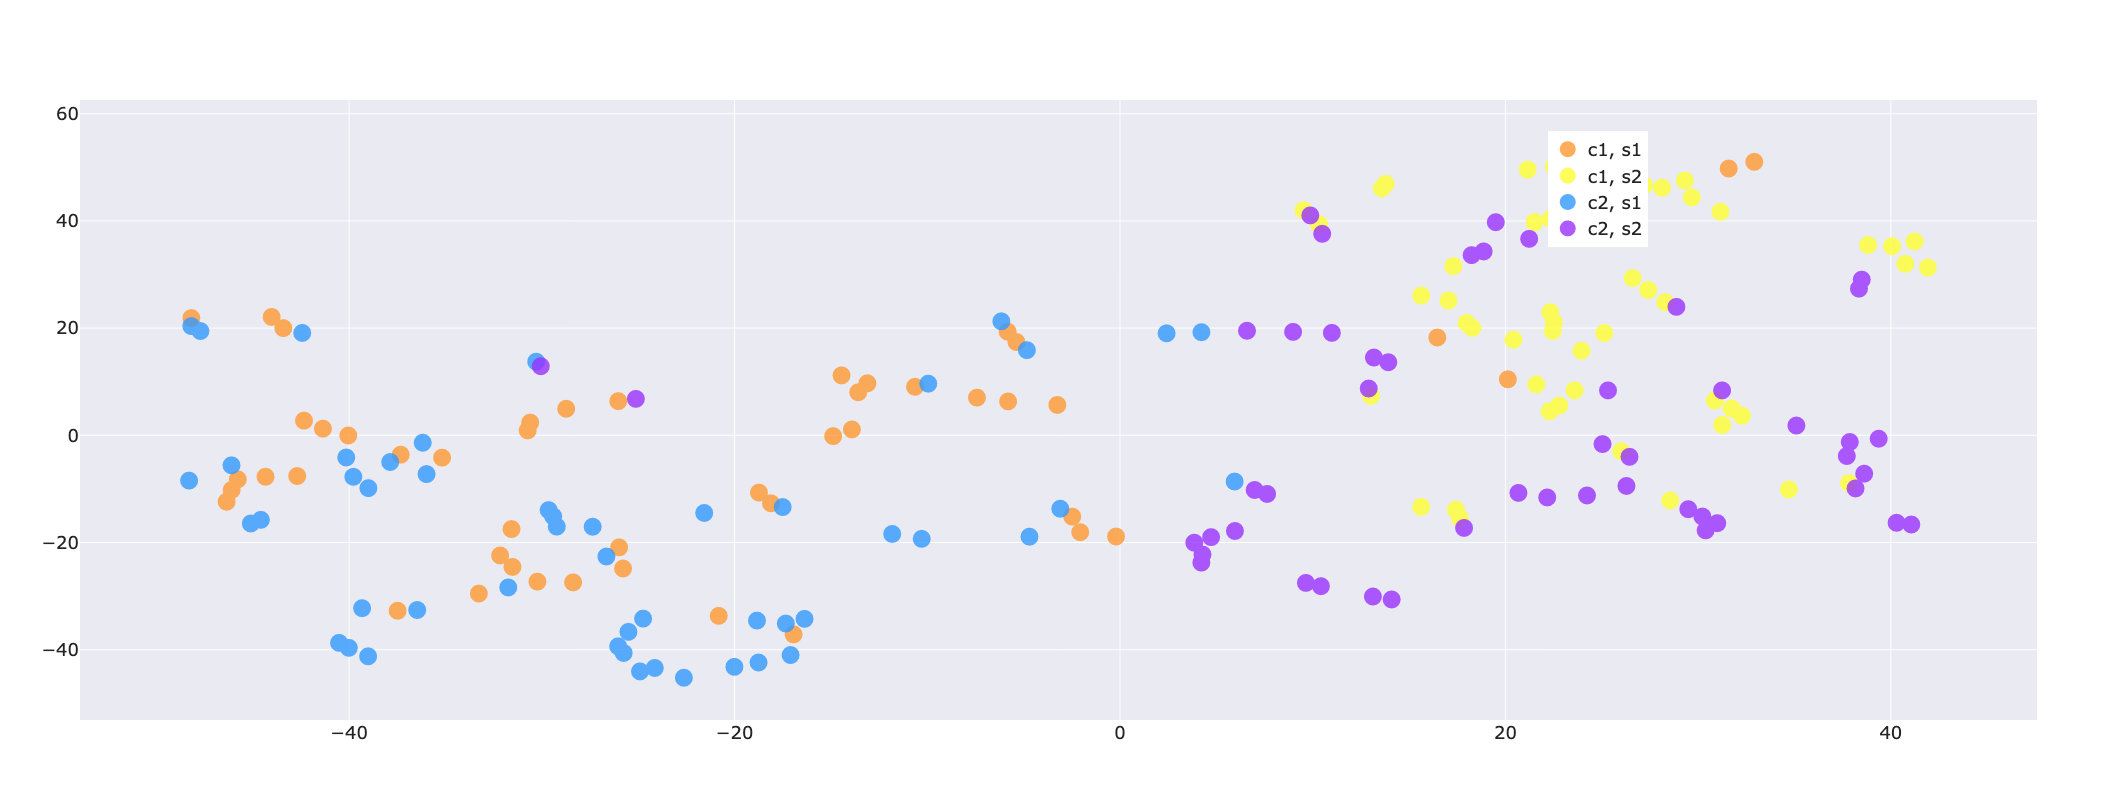

In [34]:
fig = go.Figure()

# specify color for each label (similar color for same class)
label2color = {
    'c1': {
        's1': 'rgb(255, 153, 51)',
        's2': 'rgb(255, 255, 51)',
    }, 
    'c2': {
        's1': 'rgb(51, 153, 255)',
        's2': 'rgb(153, 51, 255)',
    },
}

for c in ['c1', 'c2']:
    for s in ['s1', 's2']:
        color = label2color[c][s]

        fig.add_trace(
            go.Scatter(
                mode='markers',
                x=emb['orig'][c][s]['tsne'][:,0],
                y=emb['orig'][c][s]['tsne'][:,1],
                opacity=0.8,
                marker=dict(
                    color=color,
                    size=18,
                ),
                name=f"{c}, {s}"
            )
        )
        
        
    

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    template="seaborn",
    font=dict(
        size=18,
    ),
    #title=dict(
    #    text="test",
    #    font=dict(
    #        color="blue",
    #    ),
    #    x=0.5,
    #),
    legend=dict(
        x=.75,
        y=.95,
        traceorder="normal",
    ),
    #xaxis_title="embedding dim 1",
    #yaxis_title="embedding dim 2",
)

fig.show()

In [171]:
fig.write_image("original_embedding_visualization.svg")

### OurV1 Model
Create embeddings of all images using the model from the our approach.

In [35]:
experiment_id = "final_pretext_alpha5"
our_model = load_best_model(experiment_id, OurPretextNetwork(backbone="resnet18"))

# raw embeddings
embeddings = get_embeddings([image for c in img for s in img[c] for image in img[c][s]], our_model)

# pca embeddings
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# tsne embeddings
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

for i, c in enumerate(['c1', 'c2']):
    for j, s in enumerate(['s1', 's2']):
        start_idx = i*100+j*50
        dict_set(emb, '.'.join(['ourv1', c, s, 'raw']), embeddings[start_idx:start_idx+50])
        dict_set(emb, '.'.join(['ourv1', c, s, 'pca']), embeddings_pca[start_idx:start_idx+50])
        dict_set(emb, '.'.join(['ourv1', c, s, 'tsne']), embeddings_tsne[start_idx:start_idx+50])

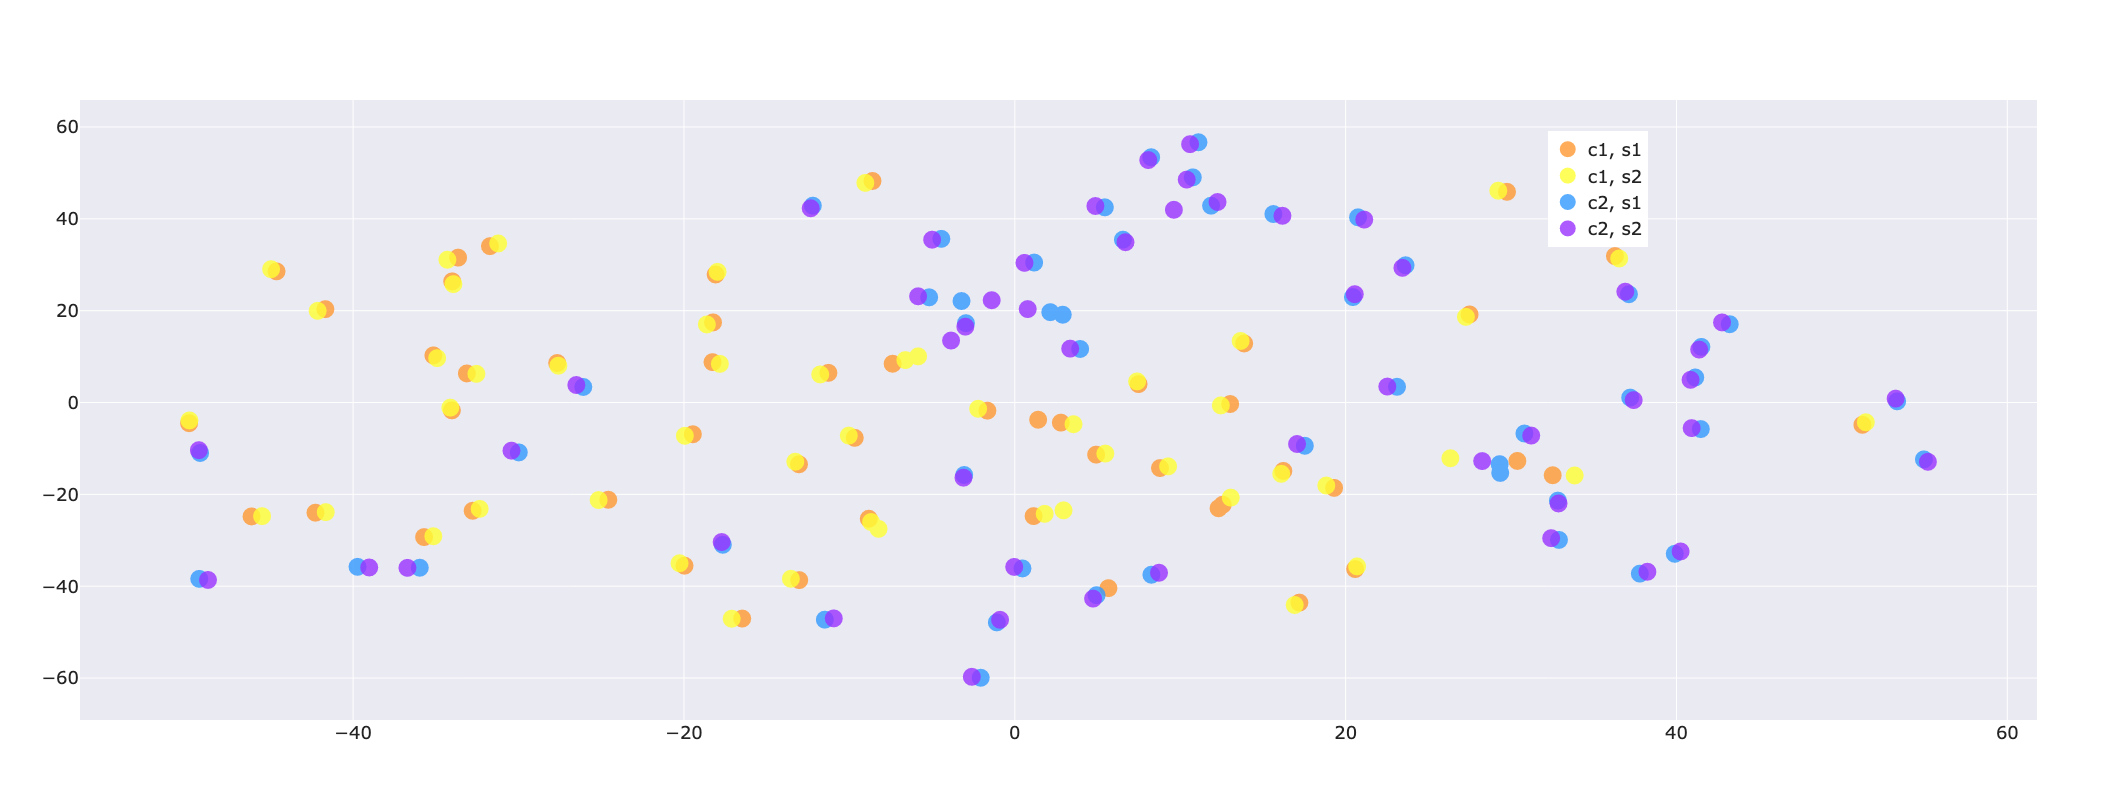

In [36]:
fig = go.Figure()

# specify color for each label (similar color for same class)
label2color = {
    'c1': {
        's1': 'rgb(255, 153, 51)',
        's2': 'rgb(255, 255, 51)',
    }, 
    'c2': {
        's1': 'rgb(51, 153, 255)',
        's2': 'rgb(153, 51, 255)',
    },
}

for c in ['c1', 'c2']:
    for s in ['s1', 's2']:
        color = label2color[c][s]

        fig.add_trace(
            go.Scatter(
                mode='markers',
                x=emb['ourv1'][c][s]['tsne'][:,0],
                y=emb['ourv1'][c][s]['tsne'][:,1],
                opacity=0.8,
                marker=dict(
                    color=color,
                    size=18,
                ),
                name=f"{c}, {s}"
            )
        )
        
        
    

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    template="seaborn",
    font=dict(
        size=18,
    ),
    #title=dict(
    #    text="test",
    #    font=dict(
    #        color="blue",
    #    ),
    #    x=0.5,
    #),
    legend=dict(
        x=.75,
        y=.95,
        traceorder="normal",
    ),
    #xaxis_title="embedding dim 1",
    #yaxis_title="embedding dim 2",
)

fig.show()

In [158]:
fig.write_image("ourv1_embedding_visualization.svg")

### OurV2 Model

In [37]:
experiment_id = "final_pretext_v2"
our_model = load_best_model(experiment_id, OurPretextNetwork(backbone="resnet18"))

# raw embeddings
embeddings = get_embeddings([image for c in img for s in img[c] for image in img[c][s]], our_model)

# pca embeddings
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# tsne embeddings
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

for i, c in enumerate(['c1', 'c2']):
    for j, s in enumerate(['s1', 's2']):
        start_idx = i*100+j*50
        dict_set(emb, '.'.join(['ourv2', c, s, 'raw']), embeddings[start_idx:start_idx+50])
        dict_set(emb, '.'.join(['ourv2', c, s, 'pca']), embeddings_pca[start_idx:start_idx+50])
        dict_set(emb, '.'.join(['ourv2', c, s, 'tsne']), embeddings_tsne[start_idx:start_idx+50])

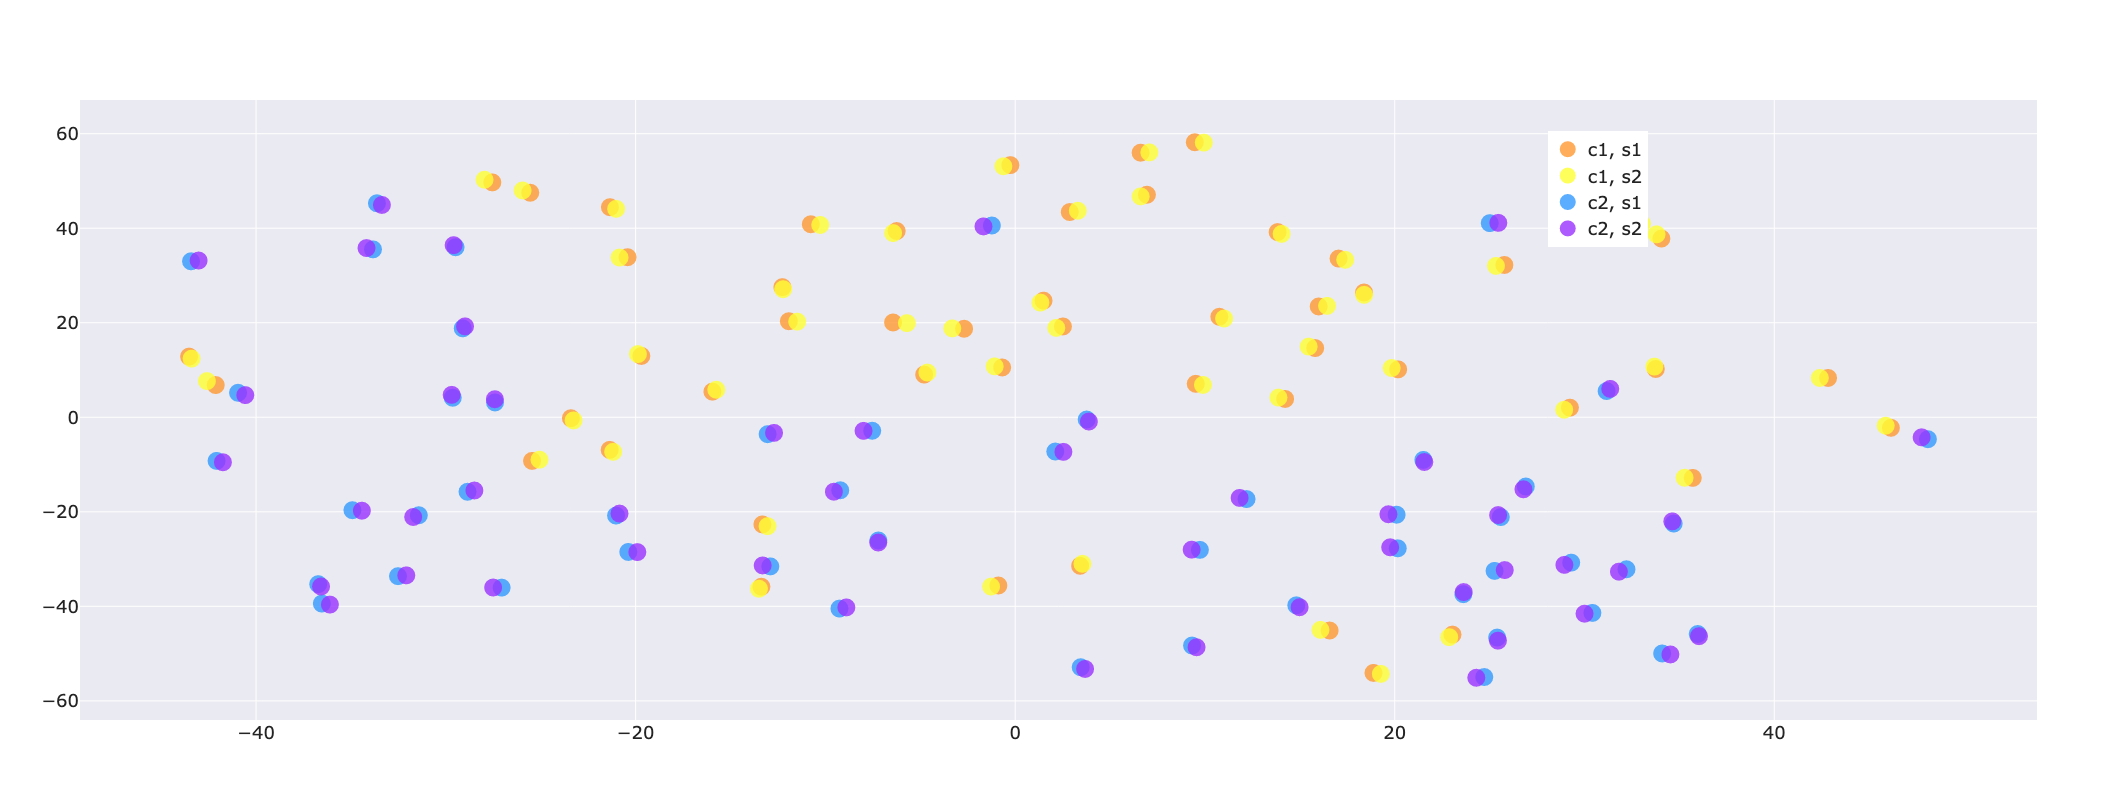

In [38]:
fig = go.Figure()

# specify color for each label (similar color for same class)
label2color = {
    'c1': {
        's1': 'rgb(255, 153, 51)',
        's2': 'rgb(255, 255, 51)',
    }, 
    'c2': {
        's1': 'rgb(51, 153, 255)',
        's2': 'rgb(153, 51, 255)',
    },
}

for c in ['c1', 'c2']:
    for s in ['s1', 's2']:
        color = label2color[c][s]

        fig.add_trace(
            go.Scatter(
                mode='markers',
                x=emb['ourv2'][c][s]['tsne'][:,0],
                y=emb['ourv2'][c][s]['tsne'][:,1],
                opacity=0.8,
                marker=dict(
                    color=color,
                    size=18,
                ),
                name=f"{c}, {s}"
            )
        )
        
        
    

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    template="seaborn",
    font=dict(
        size=18,
    ),
    #title=dict(
    #    text="test",
    #    font=dict(
    #        color="blue",
    #    ),
    #    x=0.5,
    #),
    legend=dict(
        x=.75,
        y=.95,
        traceorder="normal",
    ),
    #xaxis_title="embedding dim 1",
    #yaxis_title="embedding dim 2",
)

fig.show()

In [183]:
fig.write_image("ourv2_embedding_visualization.svg")

### OurV3 Model
Create embeddings of all images using the model from the our approach.

In [39]:
experiment_id = "dustin_pretext_ourv3"
our_model = load_best_model(experiment_id, OurPretextNetwork(backbone="resnet18"))

# raw embeddings
embeddings = get_embeddings([image for c in img for s in img[c] for image in img[c][s]], our_model)

# pca embeddings
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# tsne embeddings
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

for i, c in enumerate(['c1', 'c2']):
    for j, s in enumerate(['s1', 's2']):
        start_idx = i*100+j*50
        dict_set(emb, '.'.join(['ourv3', c, s, 'raw']), embeddings[start_idx:start_idx+50])
        dict_set(emb, '.'.join(['ourv3', c, s, 'pca']), embeddings_pca[start_idx:start_idx+50])
        dict_set(emb, '.'.join(['ourv3', c, s, 'tsne']), embeddings_tsne[start_idx:start_idx+50])

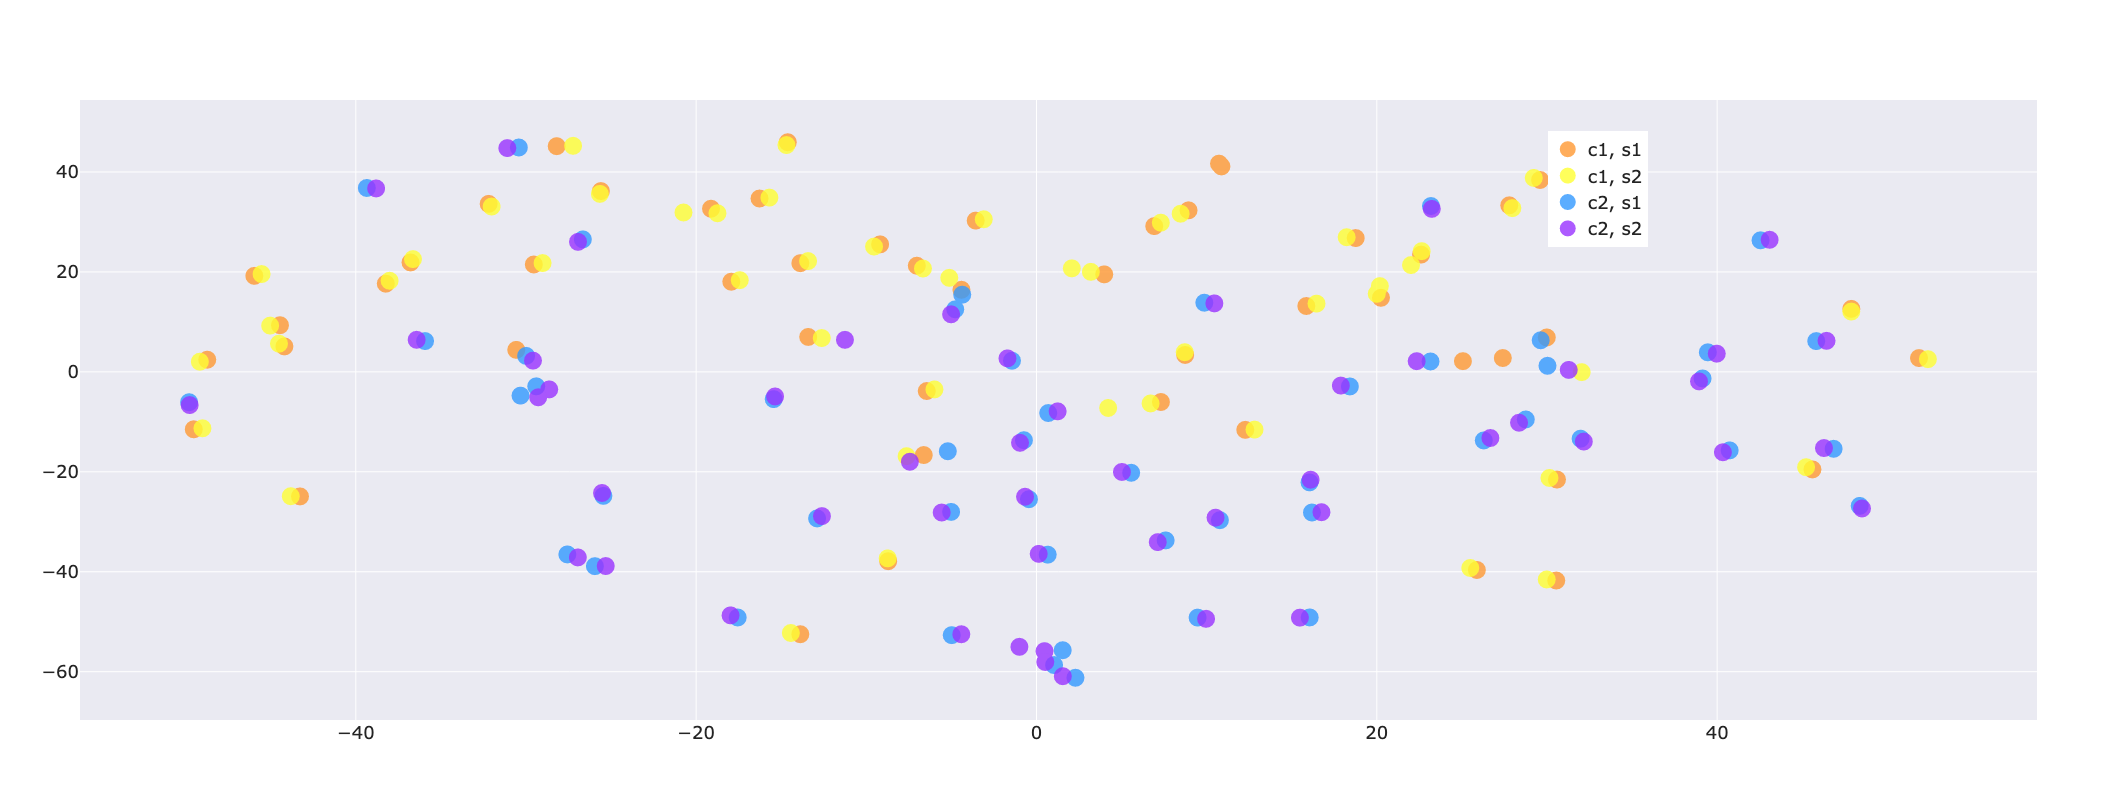

In [40]:
fig = go.Figure()

# specify color for each label (similar color for same class)
label2color = {
    'c1': {
        's1': 'rgb(255, 153, 51)',
        's2': 'rgb(255, 255, 51)',
    }, 
    'c2': {
        's1': 'rgb(51, 153, 255)',
        's2': 'rgb(153, 51, 255)',
    },
}

for c in ['c1', 'c2']:
    for s in ['s1', 's2']:
        color = label2color[c][s]

        fig.add_trace(
            go.Scatter(
                mode='markers',
                x=emb['ourv3'][c][s]['tsne'][:,0],
                y=emb['ourv3'][c][s]['tsne'][:,1],
                opacity=0.8,
                marker=dict(
                    color=color,
                    size=18,
                ),
                name=f"{c}, {s}"
            )
        )
        
        
    

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    template="seaborn",
    font=dict(
        size=18,
    ),
    #title=dict(
    #    text="test",
    #    font=dict(
    #        color="blue",
    #    ),
    #    x=0.5,
    #),
    legend=dict(
        x=.75,
        y=.95,
        traceorder="normal",
    ),
    #xaxis_title="embedding dim 1",
    #yaxis_title="embedding dim 2",
)

fig.show()

In [177]:
fig.write_image("ourv3_embedding_visualization.svg")

## Embedding Distance

In [361]:
from scipy.spatial import distance

def emb_dist(emb1, emb2):
    #return np.linalg.norm(emb1-emb2, ord=2)
    return distance.cosine(emb1, emb2)

In [362]:
for method in emb:
    print(f"{method}: {np.mean([emb_dist(emb1, emb2) for c in ['c1', 'c2'] for emb1, emb2 in zip(emb[method][c]['s1']['raw'], emb[method][c]['s2']['raw'])])}")

orig: 0.23174384772777556
ourv1: 0.09138652145862579
ourv2: 0.09379976272583007
ourv3: 0.11145715475082398


In [18]:
from src.dataset import get_tiny_imagenet_info, get_imagenet_info